# Calibration of network parameters

Based on a fixed epidemic parameters, we calibrate the network parameters to match the early period of the 2014 Ebola outbreak as reported by WHO.

In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
from matplotlib import pyplot as plt
%matplotlib inline

import os
import json
import itertools
from collections import Counter, defaultdict
import pandas as pd
import networkx as nx
import numpy as np
from multiprocessing import cpu_count, Pool

from lib.graph_generation import make_ebola_network
from lib.dynamics import SimulationSIR, PriorityQueue
from lib.dynamics import sample_seeds
from lib.settings import DATA_DIR
from lib import metrics

In [14]:
COUNTRY_LIST = ['Guinea', 'Liberia', 'Sierra Leone']

---

## 1. Set simulation parameters

Set simulation period

In [4]:
start_day_str = '2014-01-01'
end_day_str = '2014-03-01'
max_timedelta = pd.to_datetime(end_day_str) - pd.to_datetime(start_day_str)
max_days = max_timedelta.days

Set SIR infection and recovery rates

In [5]:
beta = 1 / 15.3
delta = 1 / 11.4

Experiment parameters

In [7]:
# Number of graphs to sample for each setting
n_graphs = 47 * 5
# Number simulations to run per graph
n_sims = 1000

---

## 2. Run calibration

Define a worker function that performs many SIR simulation over a single graph and returns statistics to compute $R_0$.

In [8]:
def worker(n_nodes, p_in, p_out, net_idx):
    """
    Perform many SIR simulation over a single graph sampled with the given parameters.
    Return a list of dict for summarizing each simulation with the number of secondary 
    cases split by country.
    
    Parameters
    ----------
    n_nodes : int
        Number of nodes in the graph
    p_in : float
        Within-district edge probability
    p_out : dict of float
        Between-district edge probabilities
    net_idx : int
        Index of network (used to keep track of experiments and aggregate results)
    """
    
    res_list = list()
    
    graph = make_ebola_network(n_nodes=n_nodes, p_in=p_in, p_out=p_out)

    for sim_idx in range(n_sims):

        # === Sample initial seeds
        init_event_list = sample_seeds(graph, delta=delta, 
                                       method='random', n_seeds=10, 
                                       verbose=False)
        # Extract the seeds ego-network
        seed_node_list = np.array(list(set([event[0] for event,_ in init_event_list])))
        seed_neighbors_list = np.hstack([list(graph.neighbors(u)) for u in seed_node_list])
        seed_ego_net = nx.subgraph(graph, np.hstack((seed_node_list, seed_neighbors_list)))
        # Define the stopping criteria: stop when all seeds are recovered or all
        # neighbors are infected (that is all we need to computed R_0)
        def stop_criteria(sir_obj):
            seed_node_indices = np.array([sir_obj.node_to_idx[u] for u in seed_node_list])
            seed_neighbors_indices = np.array([sir_obj.node_to_idx[u] for u in seed_neighbors_list])
            return np.all(sir_obj.is_rec[seed_node_indices]) or np.all(sir_obj.is_inf[seed_neighbors_indices])

        # === Run an SIR simulation 
        sir_obj = SimulationSIR(seed_ego_net, beta=beta, delta=delta, gamma=0.0, rho=0.0, verbose=False)
        sir_obj.launch_epidemic(
            init_event_list=init_event_list,
            max_time=max_days, 
            policy='NO', 
            stop_criteria=stop_criteria
        )

        # === Compute R0: 
        # Compute the number of secondary cases for each seed and aggregate them by country
        infector_count = Counter(sir_obj.infector)
        country_count = {country: list() for country in COUNTRY_LIST}
        for u in seed_node_list:
            u_idx = sir_obj.node_to_idx[u]
            u_country = sir_obj.G.node[u]['country']
            inf_count = infector_count[u_idx]
            country_count[u_country].append(inf_count)
        
        # Build the resulting list of summarizing dict per country for this simulation
        for country in COUNTRY_LIST:
            res_list.append({
                'country': country,
                'sim_idx': sim_idx, 
                'net_idx': net_idx,
                'p_out_gn': p_out['Guinea'],
                'p_out_lb': p_out['Liberia'], 
                'p_out_sl': p_out['Sierra Leone'],
                'count': country_count[country]
            })
    
    return res_list

Define the network parameters.

In [9]:
n_nodes = 8000
p_in = 0.01
p_out = {
           'Guinea': 0.00215,
          'Liberia': 0.00300, 
     'Sierra Leone': 0.00315, 
    'inter-country': 0.0019
}

Run simulations in parallel over many networks and simulations.

In [10]:
args_list = list()
for net_idx in range(n_graphs):
    args_list.append((n_nodes, p_in, p_out, net_idx))

n_procs = cpu_count()-1
pool = Pool(n_procs)

print(f"Run {len(args_list)} jobs on {n_procs} processes...")
res = pool.starmap(worker, args_list)

res_list = list()
for res_i in res:
    res_list.extend(res_i)

Run 940 jobs on 47 processes...


Estimate $R_0$ from all simulations.

In [11]:
res_df = pd.DataFrame(res_list)

# Aggregate results by country and graph to get R0 estimate confidence interval per country (over graphs)
res_df_gp = res_df.groupby(['country','net_idx']).agg({'count': list})
res_df_gp['N'] = res_df_gp['count'].apply(len)
res_df_gp['R0_country_and_net'] = res_df_gp['count'].apply(np.hstack).apply(np.mean)

# Aggregate results by country to get R0 estimate per country (keep)
res_df_country_gp = res_df_gp.groupby('country').agg(
    {'count': list, 'N': sum, 'R0_country_and_net': list})
res_df_country_gp['count'] = res_df_country_gp['count'].apply(np.hstack).apply(np.hstack)

res_df_country_gp['R0_mean'] = res_df_country_gp['count'].apply(np.mean)

res_df_country_gp['R0_std'] = res_df_country_gp['count'].apply(np.std)
res_df_country_gp['R0_Q5'] = res_df_country_gp['R0_country_and_net'].apply(lambda a: np.percentile(a, q=5))
res_df_country_gp['R0_Q95'] = res_df_country_gp['R0_country_and_net'].apply(lambda a: np.percentile(a, q=95))
res_df_country_gp['R0_c_net_mean'] = res_df_country_gp['R0_country_and_net'].apply(np.mean)
res_df_country_gp['R0_c_net_median'] = res_df_country_gp['R0_country_and_net'].apply(np.median)


res_df_country_gp[['N', 'R0_mean', 'R0_std', 'R0_Q5', 'R0_Q95', 'R0_c_net_median']]

,N,R0_mean,R0_std,R0_Q5,R0_Q95,R0_c_net_median
country,,,,,,
Guinea,940000,1.712507,1.856062,1.661950,1.761235,1.711272
Liberia,940000,1.836959,1.869197,1.753642,1.917458,1.835825
Sierra Leone,940000,2.011740,1.933461,1.938050,2.080164,2.012664


---

## 3. Make plots summarizing the chosen network parameters

In [68]:
deg_seq_list = list()

for _ in range(20):
    graph = make_ebola_network(n_nodes=n_nodes, p_in=p_in, p_out=p_out)
    degree_sequence = [d for n, d in graph.degree()]
    
    deg_seq_list.append(Counter(degree_sequence))
    
deg_df = pd.DataFrame(deg_seq_list).T.sort_index()
deg_df = deg_df.fillna(0.0)

deg_mean = deg_df.mean(axis=1)
deg_std = deg_df.std(axis=1)

Graph generated
  - 7450 nodes, 15849 edges
Degree distribution statistics:
  - Mean: 4.254765100671141, Median: 4.0
Cluster size statistics:
  - Minimum cluster size is: 1
  - Median cluster size is: 111
  - Average cluster size is: 135.45
  - Max cluster size is: 662


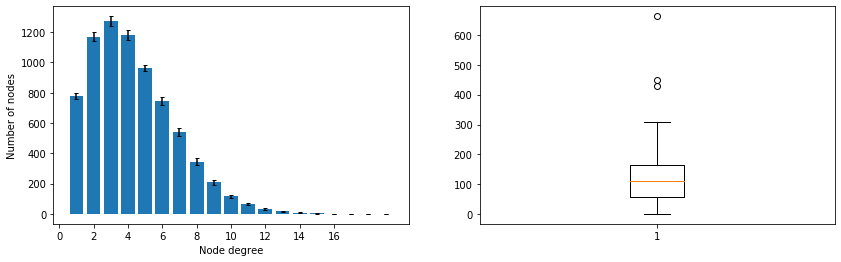

In [71]:

print('Graph generated')
print(f"  - {graph.number_of_nodes()} nodes, {graph.number_of_edges()} edges")

fig, axs = plt.subplots(1, 2, figsize=(14, 4))

plt.sca(axs[0])
print("Degree distribution statistics:")
print(f'  - Mean: {np.mean(degree_sequence)}, Median: {np.median(degree_sequence)}')
deg_x = range(1, len(deg_mean)+1)
plt.bar(deg_x, deg_mean, yerr=deg_std, align='center', ecolor='black', capsize=2)
plt.xlabel('Node degree')
plt.ylabel('Number of nodes')
plt.xticks(np.arange(0, max_deg+1, 2));

plt.sca(axs[1])
cluster_sizes = np.bincount([d['block'] for u,d in graph.nodes(data=True)])
plt.boxplot(cluster_sizes);
print("Cluster size statistics:")
print(f"  - Minimum cluster size is: {min(cluster_sizes):d}")
print(f"  - Median cluster size is: {np.median(cluster_sizes):.0f}")
print(f"  - Average cluster size is: {np.mean(cluster_sizes):.2f}")
print(f"  - Max cluster size is: {np.max(cluster_sizes):d}")

--- 

## 4. Run a simulation with the given parameters and estimate the effective reproduction number over time as reported by WHO

Run a simulation

In [24]:
graph = make_ebola_network(n_nodes=n_nodes, p_in=p_in, p_out=p_out)

init_event_list = sample_seeds(graph, delta=delta, 
                               method='data', max_date=start_day_str,
                               verbose=False)

seed_node_list = np.array(list(set([event[0] for event,_ in init_event_list])))
print('Seeds:')
print(Counter([graph.node[u]['country'] for u in seed_node_list]))
print()

sir_obj = SimulationSIR(graph, beta=beta, delta=delta, gamma=0.0, rho=0.0, verbose=True)
sir_obj.launch_epidemic(
    init_event_list=init_event_list,
    max_time=210, 
    policy='NO'
)

Seeds:
Counter({'Sierra Leone': 4, 'Guinea': 2})

Epidemic stopped after 210.00 days | 2363 sus., 8 inf., 5042 rec., 0 tre (0.00% of inf) | I(q): 8 R(q): 8 T(q): 0 |q|: 16


Aggregate the daily incidence.

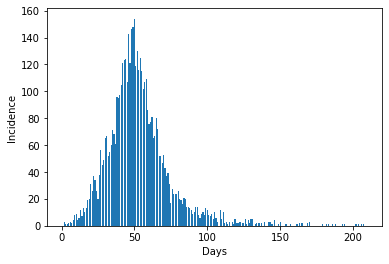

In [25]:
daily_count_arr, bins = np.histogram(
    sir_obj.inf_occured_at[(sir_obj.inf_occured_at < np.inf) & (sir_obj.inf_occured_at > 0)], 
    bins=np.arange(0, sir_obj.max_time)
)
plt.bar(bins[1:], daily_count_arr)
plt.xlabel('Days')
plt.ylabel('Incidence');

Compute $R_0$ using the method reported by WHO.

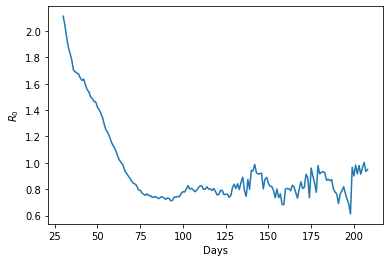

In [26]:
T = 30
rt_list = []
for i in range(1, int(sir_obj.max_time) - T):
    rt = metrics.estimate_reproduction_number(daily_count_arr[i:i+T], beta, T=T)
    rt_list.append(rt)

plt.plot(range(T, len(rt_list)+T), rt_list)
plt.ylabel('$R_0$')
plt.xlabel('Days');